<center>
<img src="https://kartinkin.net/pics/uploads/posts/2022-08/1661177142_14-kartinkin-net-p-fon-dlya-prezentatsii-konstruktor-krasivo-16.jpg" width="500"> 

# Семинар 7: нейросети — конструктор LEGO
</center>
<br>

В этом семинаре мы попробуем разные эвристики для обучения нейронных сетей и выясним, какие из них работают хорошо, а какие не очень. 

In [147]:
import warnings
warnings.filterwarnings("ignore")

In [148]:
import numpy as np
from tqdm.auto import tqdm

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

In [150]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms as T

In [151]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Будем гонять все наши сетки на MNIST, для простоты. 

In [152]:
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.1307,), (0.3081,))
    ]
)

train_dataset = torchvision.datasets.MNIST(
    'MNIST', train=True, download=True, transform=transform
)
val_dataset = torchvision.datasets.MNIST(
    'MNIST', train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=512, shuffle=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1024, shuffle=False, num_workers=4
)

Возьмём наши функции для обучения из предыдущего семинара. 

In [153]:
def train_epoch(model, optimizer, criterion):
    loss_log, acc_log = [], []
    
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        x_batch.to(device)
        y_batch.to(device)
        
        optimizer.zero_grad()
        
        # x_batch: [batch_size x num_channels x height x width]
        logits = model(x_batch)
        
        # logits: [batch_size x num_classes]
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
            
        pred = torch.max(logits, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch.data.numpy())
        acc_log.append(acc)
    return loss_log, acc_log 

In [161]:
def test(model, criterion):
    loss_log, acc_log = [], []
    
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(val_loader):
        x_batch.to(device)
        y_batch.to(device)
        
        with torch.no_grad():
            logits = model(x_batch)
            loss = criterion(logits, y_batch)

        pred = torch.max(logits, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch.data.numpy())
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

In [162]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    
    axs[0].plot(train_losses, label='train')
    
    points = np.array(test_losses)
    axs[0].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(train_accuracies, label='train')
    points = np.array(test_accuracies)
    axs[1].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('step')
        ax.legend()

    plt.show()

In [179]:
def train(model, optimizer, criterion, n_epochs, batch_size, scheduler=None):
   
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        
        train_loss, train_acc = train_epoch(model, optimizer, criterion)
        val_loss, val_acc = test(model, criterion)
        
        if scheduler is not None:
            scheduler.step()

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        steps = train_dataset.train_labels.shape[0] / batch_size
        
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))
        
        clear_output()
        plot_losses(train_log, val_log, train_acc_log, val_acc_log)  
        
    return val_log
# {
#         'train_logloss': train_log, 'train_accuracy': np.mean(train_acc),
#         'val_logloss': val_log[-1], 'val_accuracy': val_acc_log[-1],
#         'log': val_log
#     }

## 1. Затухающие и взрывающиеся градиенты

Мы не будем пытаться подобрать более удачную архитектуру, нам интересно только посмотреть на особенности обучения глубоких сетей. Давайте напишем класс, который позволит нам создавать разные модели с различными свойстами. 

Хочется, чтобы мы могли: 

- выбирать функцию активации
- выбирать способ инициализации сетки
- выбирать размер сетки 
- добавлять в сеть батчнорм

**Задание 1:** перепишите архитектуру ниже в однобном виде.

In [100]:
INPUT_SIZE = 28**2

class DeepDenseNet(nn.Module):
    
    def __init__(self, n_layers, hidden_size, activation, initialization, input_size=INPUT_SIZE):
        super().__init__()
        self.activation = activation
        self.init = initialization
        
        layer_init = nn.Linear(input_size, hidden_size)
        
        self.init(layer_init.weight)
        self.weights = [layer_init.weight]
        self.layers = [nn.Flatten(), layer_init]
        
        for i in range(n_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.init(self.layers[-1].weight)
            self.weights.append(self.layers[-1].weight)
            self.layers.append(self.activation)

        self.seq = nn.Sequential(*self.layers)
        
#         for l in self.weights:
#             l.retain_grad()
        
    def forward(self, x):
        out = self.seq(x)
        return F.log_softmax(out, dim=-1)
    

**Задание 2:** 

Модифицируйте наши функции обучения так, чтобы они также рисовали графики изменения градиентов.

In [141]:
def train_epoch_grad(model, optimizer, criterion):
    loss_log, acc_log = [], []
    grads = [[] for l in model.weights]
    
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        x_batch.to(device)
        y_batch.to(device)
        
        optimizer.zero_grad()
        
        # x_batch: [batch_size x num_channels x height x width]
        logits = model(x_batch)
        
        # logits: [batch_size x num_classes]
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
            
        pred = torch.max(logits, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch.data.numpy())
        acc_log.append(acc)
        
        for l,g in zip(model.weights, grads):
            g.append(np.linalg.norm(l.grad.numpy())) # \sqrt(sum x_i^2)
        
    return loss_log, acc_log, grads

In [142]:
def train_grad(model, optimizer, criterion, n_epochs, batch_size):
   
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    grads_log = None

    for epoch in range(n_epochs):
        
        train_loss, train_acc, grads = train_epoch_grad(model, optimizer, criterion)
        val_loss, val_acc = test(model, criterion)
        
        if grads_log is None:
            grads_log = grads
        else:
            for a,b in zip(grads_log, grads):
                a.extend(b)
        
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        steps = train_dataset.train_labels.shape[0] / batch_size
        
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))
        
        clear_output()
        plot_losses(train_log, val_log, train_acc_log, val_acc_log)  
        
    return grads_log

**Задание 3:**

Обучите сети глубины 10 и больше с сигмоидой в качестве активации. Исследуйте, как глубина влияет на качество обучения и поведение градиентов на далеких от выхода слоях. Теперь замените активацию на ReLU/ELU и посмотрите, что получится.

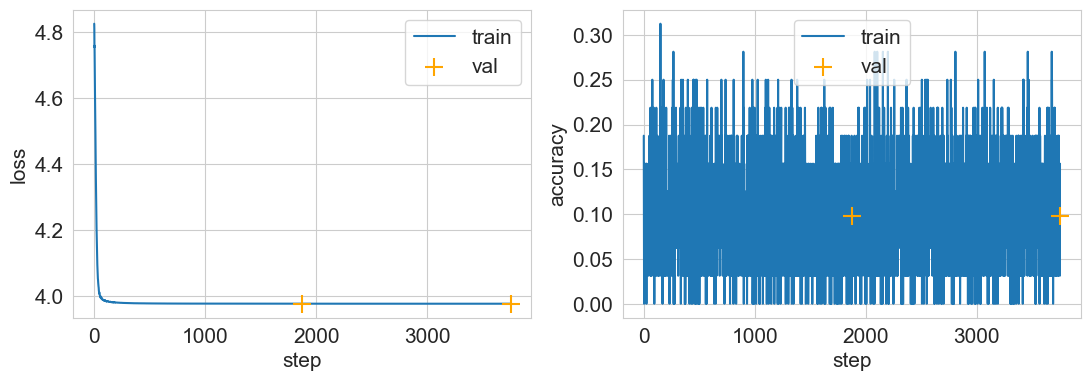

In [96]:
model = DeepDenseNet(10, 128, nn.Sigmoid()).to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

grads_log_sigm = train_grad(model, opt, criterion, 2, batch_size=32)

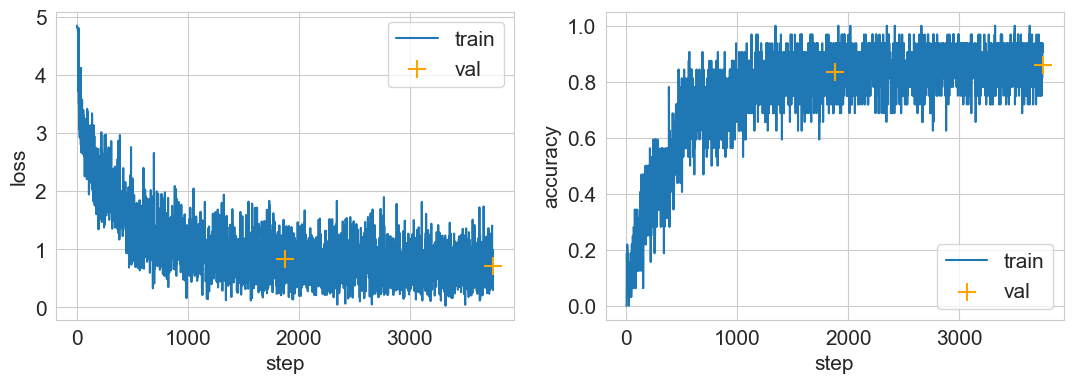

In [97]:
model = DeepDenseNet(10, 128, nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

grads_log_relu = train_grad(model, opt, criterion, 2, batch_size=32)

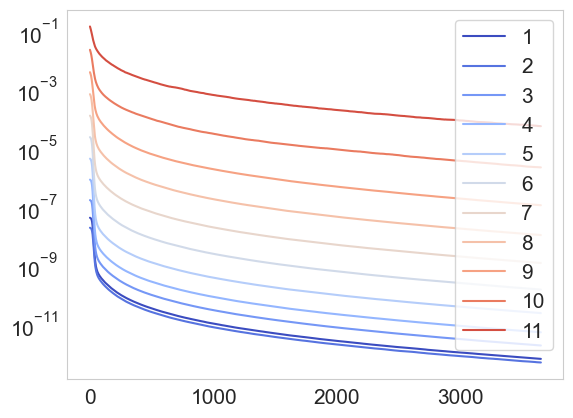

In [98]:
plt.figure()
all_vals = []
for i, g in enumerate(grads_log_sigm):
    w = np.ones(100)
    w /= w.sum()
    vals = np.convolve(w, g, mode='valid')
    plt.semilogy(vals, label=str(i+1), color=plt.cm.coolwarm((i / len(grads_log_sigm))))
    all_vals.extend(vals)
plt.legend(loc='best')
plt.grid()
plt.show()

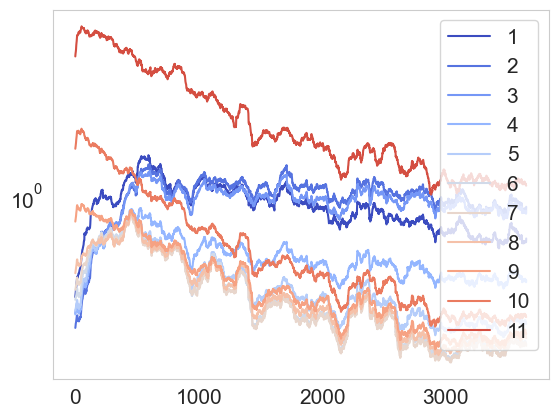

In [99]:
plt.figure()
all_vals = []
for i, g in enumerate(grads_log_relu):
    w = np.ones(100)
    w /= w.sum()
    vals = np.convolve(w, g, mode='valid')
    plt.semilogy(vals, label=str(i+1), color=plt.cm.coolwarm((i / len(grads_log_relu))))
    all_vals.extend(vals)
plt.legend(loc='best')
plt.grid()
plt.show()

Теперь попробуем добавить в сеть skip-connections (по примеру ResNet) вместо замены сигмоиды на relu и посмотрим, что получится. Запихнуть все слои в `nn.Sequential` и просто их применить теперь не получится - вместо этого мы их применим вручную. Но положить их в отдельный модуль `nn.Sequential` все равно нужно, иначе torch не сможет их найти и оптимизировать.

**Задание 4:** допишите недостающую часть кода ниже.

In [164]:
class DeepDenseResNet(nn.Module):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation
        
        l0 = nn.Linear(X_train.shape[1], hidden_size)
        self.weights = [l0.weight]
        self.layers = [l0]
        
        for i in range(1, n_layers - 1):
            l = nn.Linear(hidden_size, hidden_size)
            self.layers.append(l)
            self.weights.append(l.weight)
            
        l = nn.Linear(hidden_size, 10)
        self.layers.append(l)
        self.weights.append(l.weight)
        
        self.seq = nn.Sequential(*self.layers)
        
        for l in self.weights:
            l.retain_grad()
        
    def forward(self, x):
        
        # <your code here>
        
        return F.log_softmax(x, dim=-1)

In [ ]:
# ваш код

Убедимся, что такая сеть отлично учится даже на большом числе слоев.

In [ ]:
model = DeepDenseResNet(n_layers=20, hidden_size=10, activation=nn.Sigmoid)
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)

train_grad(model, opt, 10)

## 2. Инициализация и нормализация по батчам

**Задание 5:**

Обучите ту же самую сетку с двумя разными инициализацией: равномерной и Хе/Глорота. Сравните траектории обучения. 

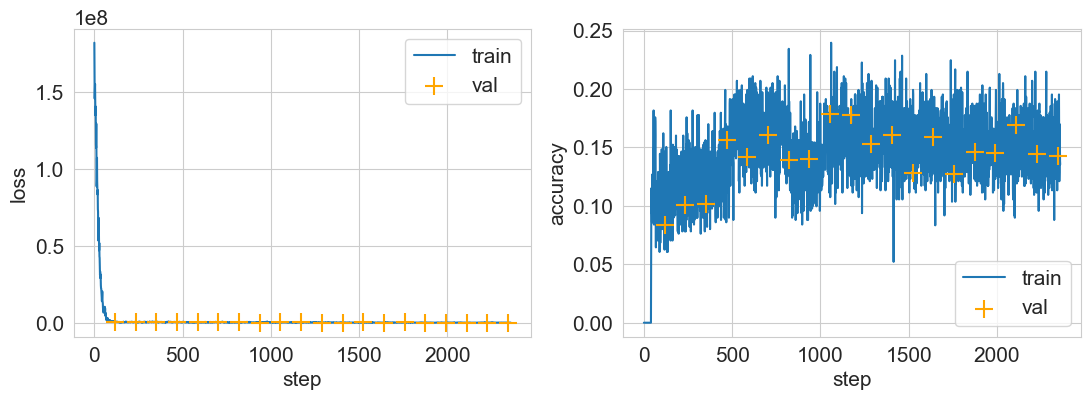

In [165]:
model = DeepDenseNet(5, 64, nn.ReLU(), torch.nn.init.uniform).to(device)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

hist_uniform = train(model, opt, criterion, 20, batch_size=512)

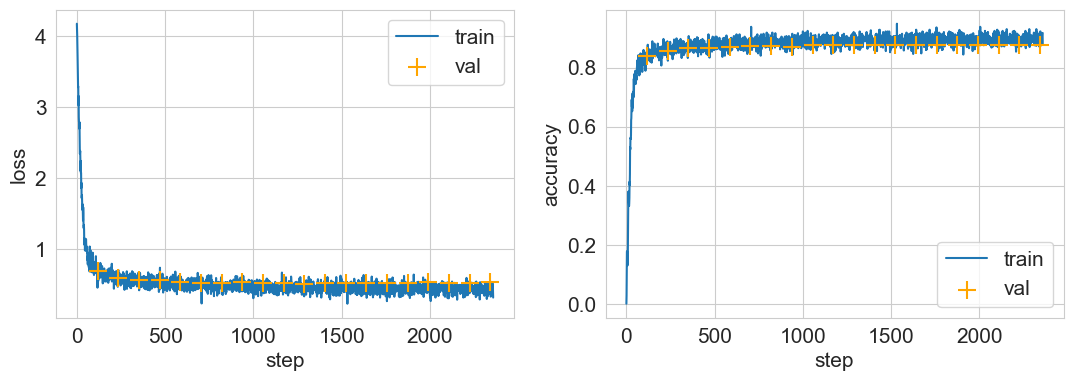

In [166]:
model = DeepDenseNet(5, 64, nn.ReLU(), torch.nn.init.xavier_uniform).to(device)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

hist_xavier = train(model, opt, criterion, 20, batch_size=512)

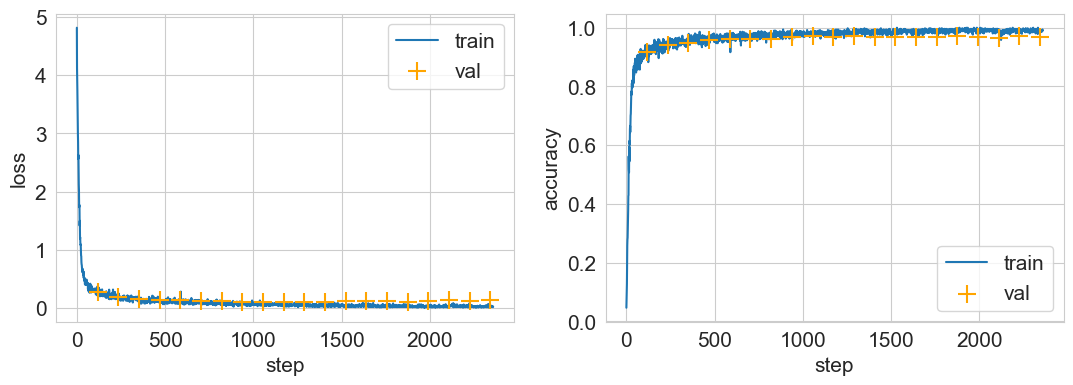

In [167]:
model = DeepDenseNet(5, 64, nn.ReLU(), torch.nn.init.kaiming_uniform).to(device)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

hist_kaming = train(model, opt, criterion, 20, batch_size=512)

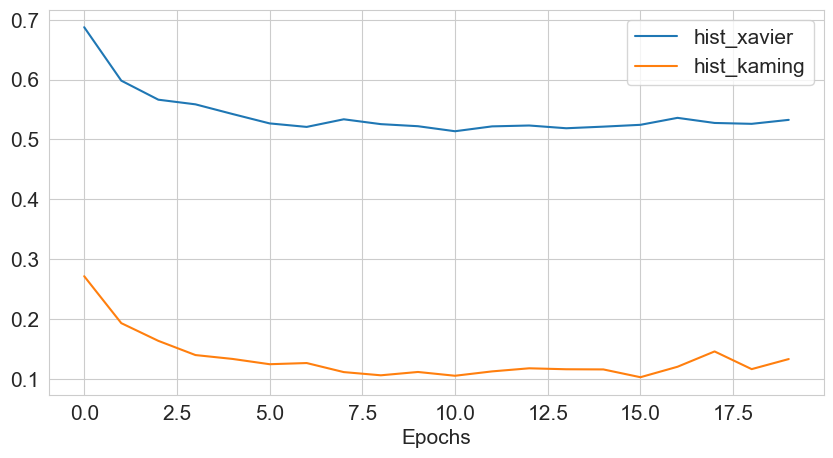

In [183]:
def plot_history(histories, start=0):
    plt.figure(figsize=(10,5))
    
    for name, history in histories:
        x = [item[1] for item in history]
        val = plt.plot(x[start:], label=name)

    plt.xlabel('Epochs')
    plt.legend()

    
plot_history([
#     ('uniform', hist_uniform),
    ('hist_xavier', hist_xavier),
    ('hist_kaming', hist_kaming)
])

**Задание 6:**

Обучите ту же самую сетку с нормализацией по батчам. Сравните траектории обучения между собой.

In [ ]:
# ваш код

## 3. Градиентный спуск

**Задание 7:** 

Попробуйте Adam с weight decay и AdamW, сравните траектории обучения между собой. 

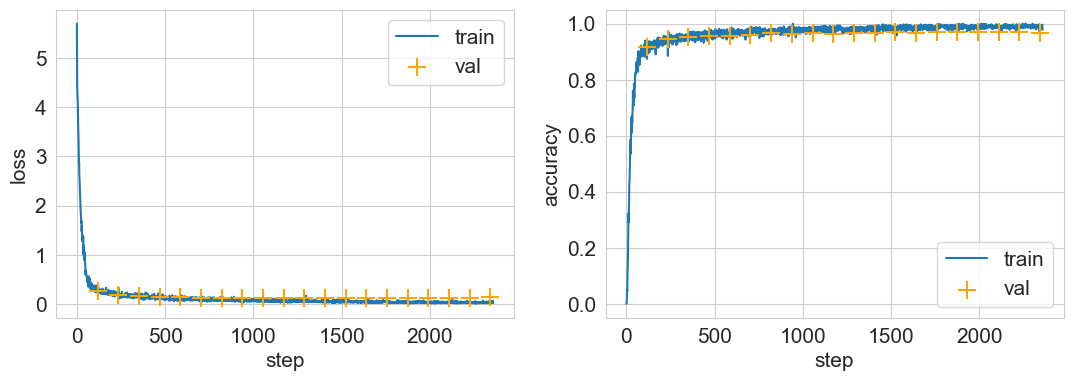

In [177]:
model = DeepDenseNet(5, 64, nn.ReLU(), torch.nn.init.kaiming_uniform).to(device)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

hist_adam = train(model, opt, criterion, 20, batch_size=512)

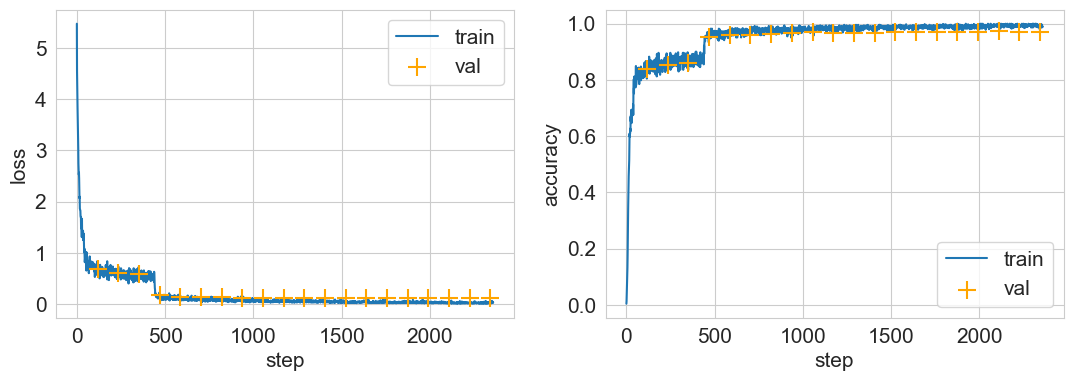

In [180]:
model = DeepDenseNet(5, 64, nn.ReLU(), torch.nn.init.kaiming_uniform).to(device)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

hist_adam_wd = train(model, opt, criterion, 20, batch_size=512)

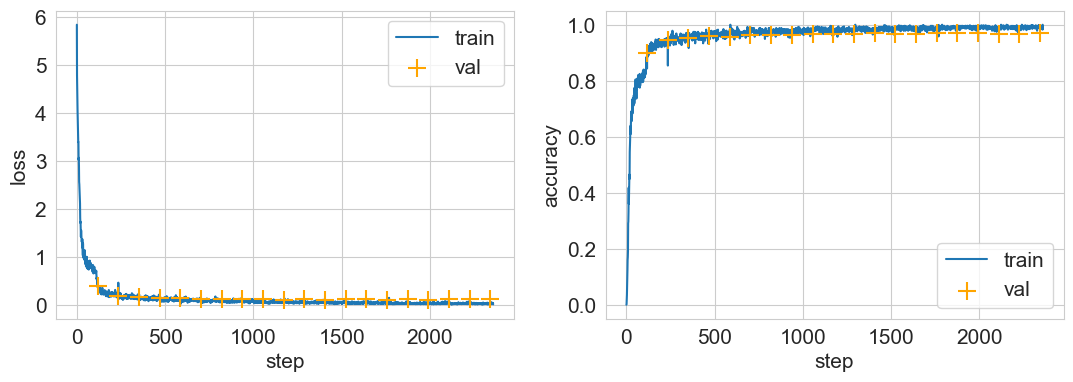

In [181]:
model = DeepDenseNet(5, 64, nn.ReLU(), torch.nn.init.kaiming_uniform).to(device)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters())

hist_adamW = train(model, opt, criterion, 20, batch_size=512)

In [ ]:
model = DeepDenseNet(5, 64, nn.ReLU(), torch.nn.init.kaiming_uniform).to(device)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.A(model.parameters())

hist_adamAB = train(model, opt, criterion, 20, batch_size=512)

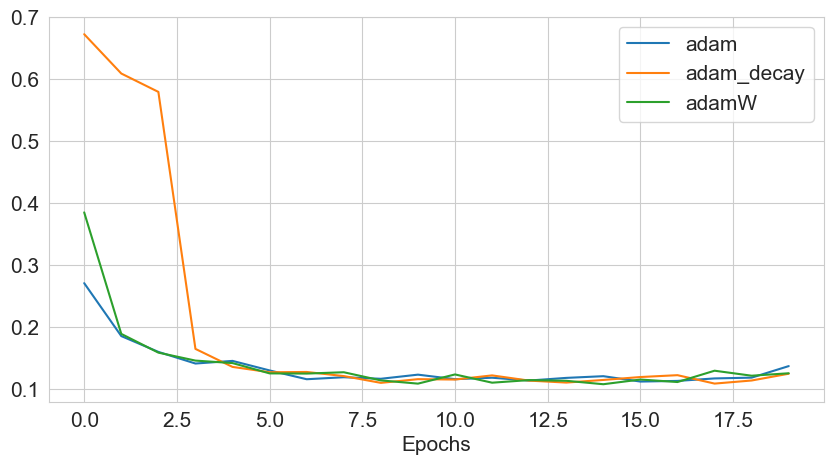

In [188]:
plot_history([
    ('adam', hist_adam),
    ('adam_decay', hist_adam_wd),
    ('adamW', hist_adamW)
], start=0)

**Задание 8:** 

Добавьте в функцию обучения шедулинг с каким-нибудь расписанием. Сравните траектории обучения. 

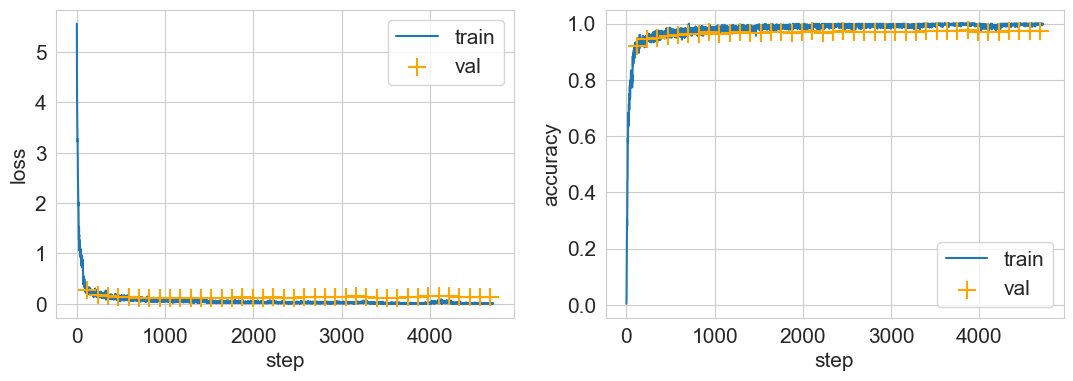

In [193]:
model = DeepDenseNet(5, 64, nn.ReLU(), torch.nn.init.kaiming_uniform).to(device)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters())

hist_adamW = train(model, opt, criterion, 40, batch_size=512)

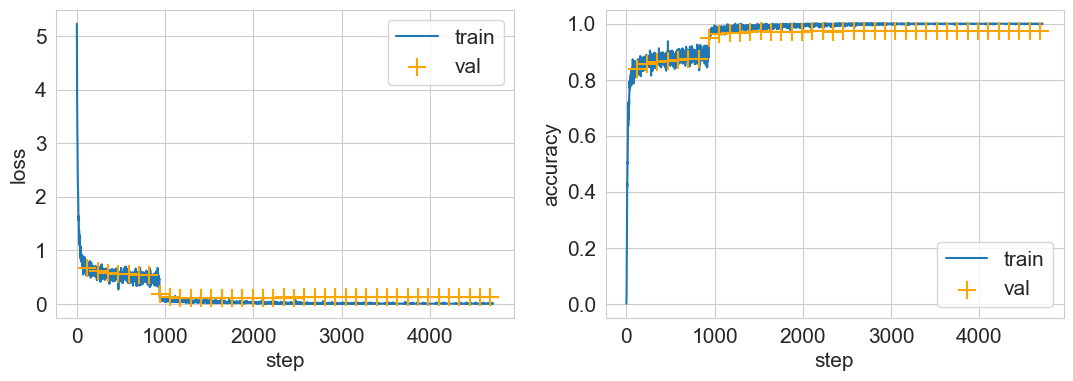

In [194]:
model = DeepDenseNet(5, 64, nn.ReLU(), torch.nn.init.kaiming_uniform).to(device)

num_epochs = 40
criterion = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, num_epochs)

hist_adam_cos = train(model, opt, criterion, num_epochs, batch_size=512, scheduler=scheduler)

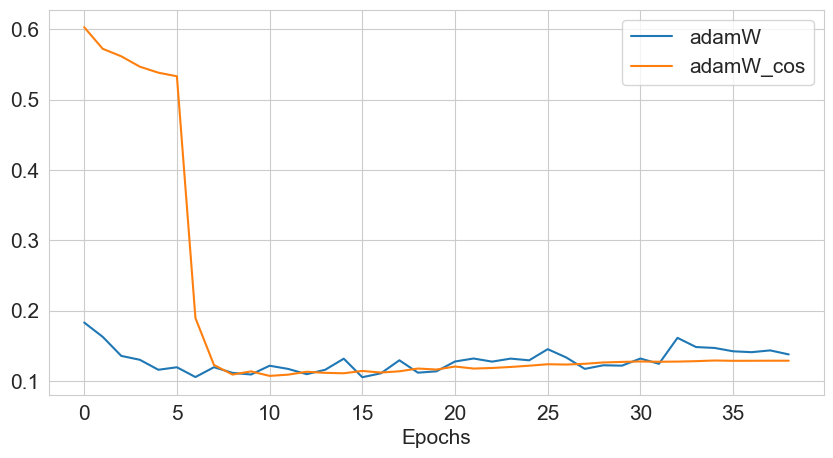

In [200]:
plot_history([
    ('adamW', hist_adamW),
    ('adamW_cos', hist_adam_cos)
], start=1)

**Задание 9:** 

Попробуйте `LRFinder`

In [ ]:
# ваш код 

In [ ]:
# посмотрим в следующий раз :) 

**Задание 10:**

Попробуйте посравнивать между собой разные оптимайзеры. 

In [ ]:
# ваш код

**Задание 11:**

Попробуйте вместо своих картинок в matplotlib использовать нормальный инструмент визуализации. Например, https://wandb.ai/quickstart

------------------------------------------